In [946]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import *
from collections import Counter
import pickle as pkl
import gradio as gr

# ========== LOAD DATA ==========

In [949]:
fpaData = pd.read_csv("FloodData.csv")
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,Short Dry Season,middleland,True,False,False,False,False,0.4,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,Long Rainy Season,upland,False,True,True,False,True,0.6,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,Short Dry Season,middleland,False,False,True,False,True,0.7,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,Short Dry Season,middleland,True,False,True,False,True,0.8,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,Short Dry Season,upland,False,True,False,False,False,1.1,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,Short Rainy Season,lowland,False,True,False,True,True,160.6,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,Short Rainy Season,lowland,True,False,False,False,True,161.8,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,Short Rainy Season,lowland,True,False,True,True,True,164.1,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,Long Rainy Season,lowland,False,True,False,False,True,172.3,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


In [950]:
print(fpaData.columns.tolist())

['record_id', 'date', 'season', 'location_type', 'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested', 'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity', 'wind_speed', 'pressure', 'flood_probability', 'flood', 'latitude', 'longitude']


In [951]:
fpaData.isnull().sum()


record_id               0
date                    0
season                  0
location_type           0
has_river               0
has_lake                0
has_poor_drainage       0
is_urban                0
is_deforested           0
rainfall_mm          1728
water_level_m           0
soil_moisture           0
temp_c                  0
humidity                0
wind_speed              0
pressure                0
flood_probability       0
flood                   0
latitude                0
longitude               0
dtype: int64

In [952]:
# Impute using group mean (season + location_type)
fpaData['rainfall_mm'] = fpaData.groupby(['season', 'location_type'])['rainfall_mm'].transform(
    lambda x: x.fillna(x.mean())
)

# Fill remaining missing (if any group was all NaN)
fpaData['rainfall_mm'] = fpaData['rainfall_mm'].fillna(fpaData['rainfall_mm'].mean())


In [956]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,Short Dry Season,middleland,True,False,False,False,False,0.400000,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,Long Rainy Season,upland,False,True,True,False,True,0.600000,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,Short Dry Season,middleland,False,False,True,False,True,0.700000,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,Short Dry Season,middleland,True,False,True,False,True,0.800000,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,Short Dry Season,upland,False,True,False,False,False,1.100000,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,Short Rainy Season,lowland,False,True,False,True,True,160.600000,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,Short Rainy Season,lowland,True,False,False,False,True,161.800000,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,Short Rainy Season,lowland,True,False,True,True,True,164.100000,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,Long Rainy Season,lowland,False,True,False,False,True,172.300000,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


# ========== ENCODE season and location_type AS INTEGERS ==========

In [960]:
# Define helper functions to clean strings safely (skip non-strings)
def clean_season(val):
    if isinstance(val, str):
        return val.strip().title()
    else:
        return None  # or pd.NA

def clean_location(val):
    if isinstance(val, str):
        return val.strip().lower()
    else:
        return None  # or pd.NA

fpaData['season'] = fpaData['season'].apply(clean_season)
fpaData['location_type'] = fpaData['location_type'].apply(clean_location)

print("\nCleaned Data:")
print(fpaData)



Cleaned Data:
       record_id        date              season location_type  has_river  \
0              1    1/1/2023    Short Dry Season    middleland       True   
1              2    5/9/2020   Long Rainy Season        upland      False   
2              3  12/23/2023    Short Dry Season    middleland      False   
3              4   2/24/2022    Short Dry Season    middleland       True   
4              5  12/31/2021    Short Dry Season        upland      False   
...          ...         ...                 ...           ...        ...   
87595      87596  11/30/2021  Short Rainy Season       lowland      False   
87596      87597   11/9/2015  Short Rainy Season       lowland       True   
87597      87598   9/11/2015  Short Rainy Season       lowland       True   
87598      87599    4/2/2021   Long Rainy Season       lowland      False   
87599      87600   9/10/2017  Short Rainy Season       lowland      False   

       has_lake  has_poor_drainage  is_urban  is_deforested 

In [961]:
# 2. Encode season and location_type
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

fpaData['season'] = fpaData['season'].map(season_mapping)
fpaData['location_type'] = fpaData['location_type'].map(location_mapping)
# ✅ Validate mappings
if fpaData['season'].isnull().any():
    print("⚠️ Some season values failed to map!")

if fpaData['location_type'].isnull().any():
    print("⚠️ Some location_type values failed to map!")
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,4,2,True,False,False,False,False,0.400000,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,1,3,False,True,True,False,True,0.600000,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,4,2,False,False,True,False,True,0.700000,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,4,2,True,False,True,False,True,0.800000,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,4,3,False,True,False,False,False,1.100000,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,2,1,False,True,False,True,True,160.600000,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,2,1,True,False,False,False,True,161.800000,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,2,1,True,False,True,True,True,164.100000,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,1,1,False,True,False,False,True,172.300000,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


In [963]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,4,2,True,False,False,False,False,0.400000,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,1,3,False,True,True,False,True,0.600000,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,4,2,False,False,True,False,True,0.700000,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,4,2,True,False,True,False,True,0.800000,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,4,3,False,True,False,False,False,1.100000,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,2,1,False,True,False,True,True,160.600000,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,2,1,True,False,False,False,True,161.800000,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,2,1,True,False,True,True,True,164.100000,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,1,1,False,True,False,False,True,172.300000,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


In [971]:
fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,4,2,True,False,False,False,False,0.400000,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,1,3,False,True,True,False,True,0.600000,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,4,2,False,False,True,False,True,0.700000,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,4,2,True,False,True,False,True,0.800000,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,4,3,False,True,False,False,False,1.100000,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,2,1,False,True,False,True,True,160.600000,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,2,1,True,False,False,False,True,161.800000,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,2,1,True,False,True,True,True,164.100000,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,1,1,False,True,False,False,True,172.300000,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


In [973]:
# 3. Convert boolean features to integers
bool_cols = ['has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested']
for col in bool_cols:
    fpaData[col] = fpaData[col].astype(int)

fpaData

,record_id,date,season,location_type,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,flood_probability,flood,latitude,longitude
0,1,1/1/2023,4,2,1,0,0,0,0,0.400000,0.58,20.0,20.6,45.3,7.9,1009.8,0.181,0,-1.572136,29.515545
1,2,5/9/2020,1,3,0,1,1,0,1,0.600000,0.39,20.0,24.1,56.9,5.6,1004.7,0.324,0,-1.059620,30.286475
2,3,12/23/2023,4,2,0,0,1,0,1,0.700000,0.51,20.0,23.5,49.6,3.7,1007.7,0.079,0,-1.749638,29.754315
3,4,2/24/2022,4,2,1,0,1,0,1,0.800000,0.35,20.0,26.3,45.4,12.6,1013.6,0.215,0,-1.959520,29.917268
4,5,12/31/2021,4,3,0,1,0,0,0,1.100000,0.36,20.0,24.1,68.9,11.8,1013.3,0.102,0,-1.454356,30.175828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87595,87596,11/30/2021,2,1,0,1,0,1,1,160.600000,3.50,100.0,23.9,100.0,9.7,1012.0,0.990,1,-2.539320,28.963445
87596,87597,11/9/2015,2,1,1,0,0,0,1,161.800000,3.50,100.0,18.7,100.0,12.4,1008.6,0.990,1,-2.427609,29.209905
87597,87598,9/11/2015,2,1,1,0,1,1,1,164.100000,3.50,100.0,19.7,100.0,5.9,1021.3,0.990,1,-2.886268,29.061142
87598,87599,4/2/2021,1,1,0,1,0,0,1,172.300000,3.50,100.0,20.3,100.0,7.3,1012.7,0.990,1,-2.274192,28.965119


# Exploratory Data Analysis

# ========== SELECT FEATURES AND TARGET ==========

In [977]:
# 4. Select features and target
features = [
    'rainfall_mm', 'water_level_m', 'soil_moisture', 'temp_c', 'humidity',
    'wind_speed', 'pressure',
    'has_river', 'has_lake', 'has_poor_drainage', 'is_urban', 'is_deforested',
    'season', 'location_type'
]
target = 'flood'

X = fpaData[features]
y = fpaData[target]

# ========== SPLIT DATA ==========

In [980]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ========== Train models ==========

In [983]:
X_train

,rainfall_mm,water_level_m,soil_moisture,temp_c,humidity,wind_speed,pressure,has_river,has_lake,has_poor_drainage,is_urban,is_deforested,season,location_type
59845,8.46304,0.53,44.7,27.4,61.2,4.8,1009.8,0,1,1,1,0,4,3
38347,10.50000,0.57,38.6,22.4,59.7,14.2,1017.9,1,1,1,1,0,1,3
11421,7.80000,0.72,31.9,24.7,50.8,9.9,1014.1,0,0,1,1,1,4,2
65342,22.90000,0.94,47.1,22.3,55.6,12.6,1017.6,1,0,1,1,1,3,1
80677,46.20000,1.66,59.8,25.8,88.3,6.8,1011.5,0,0,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,4.10000,0.50,30.0,26.6,54.1,12.0,1020.7,0,0,1,1,0,3,3
54886,26.10000,0.98,43.0,25.8,60.0,1.5,1007.7,1,1,1,0,0,1,2
76820,40.90000,1.30,54.9,24.5,72.5,3.8,1010.2,0,0,1,1,0,2,1
860,10.20000,0.55,25.3,25.2,54.5,13.9,1004.3,1,1,1,1,0,2,3


# ==========Initialize models ==========

In [986]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit models
rf_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [987]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

# Store results
evaluation_results = []

# Extended function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Save results for plotting
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': auc if auc is not None else 0
    })

    print(f"📊 Evaluation for {name}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)

# Run evaluation
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(knn_model, X_test, y_test, "KNN")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


📊 Evaluation for Random Forest
Accuracy: 0.9715753424657534
Precision: 0.9731486414491209
Recall: 0.9737711909585244
F1 Score: 0.9734598166702195
ROC AUC: 0.9947663750106265

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      8141
           1       0.97      0.97      0.97      9379

    accuracy                           0.97     17520
   macro avg       0.97      0.97      0.97     17520
weighted avg       0.97      0.97      0.97     17520

--------------------------------------------------
📊 Evaluation for KNN
Accuracy: 0.7790525114155251
Precision: 0.8123865698729582
Recall: 0.7636208551018232
F1 Score: 0.787249244297884
ROC AUC: 0.8543694885899169

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      8141
           1       0.81      0.76      0.79      9379

    accuracy                           0.78     17520
   macro avg     

C:\Users\user\AppData\Local\Temp\ipykernel_2832\1059058900.py:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_2832\1059058900.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("model_comparison.png")
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


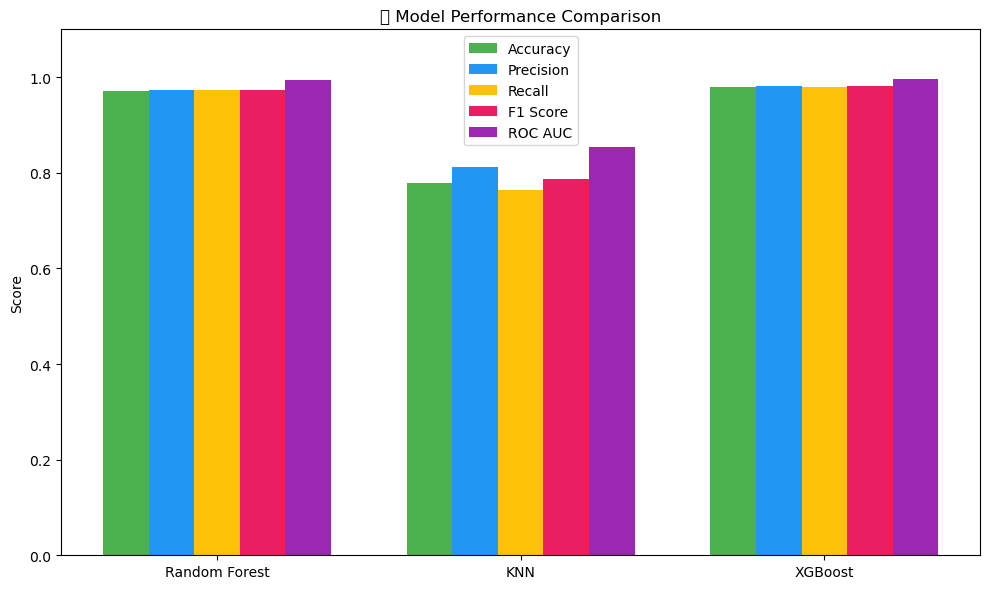

In [988]:
# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.15
index = range(len(results_df))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['#4CAF50', '#2196F3', '#FFC107', '#E91E63', '#9C27B0']

for i, metric in enumerate(metrics):
    plt.bar(
        [x + i * bar_width for x in index],
        results_df[metric],
        width=bar_width,
        label=metric,
        color=colors[i]
    )

plt.xticks([r + bar_width * 2 for r in index], results_df['Model'])
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("📊 Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


In [989]:
# Save Models
pkl.dump(rf_model, open('randomModel_flood_prediction_model.pkl', 'wb'))
pkl.dump(knn_model, open('kModel_flood_prediction_model.pkl', 'wb'))
pkl.dump(xgb_model, open('xgbModel_flood_prediction_model.pkl', 'wb'))


# ========== Test models ==========

In [991]:

# Load trained models
rf_model = pkl.load(open('randomModel_flood_prediction_model.pkl', 'rb'))
knn_model = pkl.load(open('kModel_flood_prediction_model.pkl', 'rb'))
xgb_model = pkl.load(open('xgbModel_flood_prediction_model.pkl', 'rb'))

# Categorical mappings
season_mapping = {
    "Long Rainy Season": 1,
    "Short Rainy Season": 2,
    "Long Dry Season": 3,
    "Short Dry Season": 4
}
location_mapping = {
    "lowland": 1,
    "middleland": 2,
    "upland": 3
}

# Risk categorization helper
def categorize_risk(prob):
    if prob >= 0.8:
        return "🚨 High Flood Risk"
    elif prob >= 0.5:
        return "⚠️ Medium Flood Risk"
    else:
        return "✅ Low Flood Risk"

# Prediction function
def predict_flood(rainfall, water_level, soil_moisture, temp, humidity,
                  wind_speed, pressure, has_river, has_lake, has_poor_drainage,
                  is_urban, is_deforested, season, location_type, model_choice):

    season_code = season_mapping.get(season, 0)
    location_code = location_mapping.get(location_type, 0)

    input_data = pd.DataFrame([{
        'rainfall_mm': rainfall,
        'water_level_m': water_level,
        'soil_moisture': soil_moisture,
        'temp_c': temp,
        'humidity': humidity,
        'wind_speed': wind_speed,
        'pressure': pressure,
        'has_river': int(has_river),
        'has_lake': int(has_lake),
        'has_poor_drainage': int(has_poor_drainage),
        'is_urban': int(is_urban),
        'is_deforested': int(is_deforested),
        'season': season_code,
        'location_type': location_code
    }])

    # Choose model
    if model_choice == "Random Forest":
        model = rf_model
    elif model_choice == "KNN":
        model = knn_model
    elif model_choice == "XGBoost":
        model = xgb_model
    else:
        return "❌ Invalid Model", "N/A"

    # Predict
    prediction = model.predict(input_data)[0]
    try:
        prob = model.predict_proba(input_data)[0][1]
        prob_str = f"{prob:.4f}"
        risk = categorize_risk(prob)
    except:
        prob_str = "N/A"
        risk = "Risk level unavailable"

    return risk, prob_str


In [992]:
interface = gr.Interface(
    fn=predict_flood,
    inputs=[
        gr.Number(label="Rainfall (mm)"),
        gr.Number(label="Water Level (m)"),
        gr.Number(label="Soil Moisture"),
        gr.Number(label="Temperature (°C)"),
        gr.Number(label="Humidity (%)"),
        gr.Number(label="Wind Speed"),
        gr.Number(label="Pressure"),
        gr.Checkbox(label="Has River"),
        gr.Checkbox(label="Has Lake"),
        gr.Checkbox(label="Has Poor Drainage"),
        gr.Checkbox(label="Is Urban"),
        gr.Checkbox(label="Is Deforested"),
        gr.Radio(choices=list(season_mapping.keys()), label="Season"),
        gr.Radio(choices=list(location_mapping.keys()), label="Location Type"),
        gr.Radio(choices=["Random Forest", "KNN", "XGBoost"], label="Model to Use")
    ],
    outputs=[
        gr.Label(label="Flood Risk Level"),
        gr.Textbox(label="Flood Probability")
    ],
    title="🌊 Flood Risk Prediction App",
    description="Input environmental conditions and choose a model to predict flood risk level and probability."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.
